#### Generate the scores/metrics given true y and the probabilities from the models (Test set 1 - pre-re-calibration)

* Calculate:

    * True Positive
    * True Negative
    * False Positive
    * False Negative
    * Precision
    * Recall
    * F1
    * Calibration Slope
    
* Generate:
    * Histogram of probabilities
    * Calibration Curve
    * Logits and true test results for recalibration

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, auc, precision_recall_curve, roc_auc_score
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import tensorflow as tf

#### Functions

In [10]:
def draw_calibration_curve(true_y, pred_y, run_name):
    """
    Plot a calibration curve for a binary model
    
    Args:
        true_y (list): list of single integer arrays with 0 or 1 depending on the class
        pred_y (logits tensor): logits probability of each class shape=(number_of_timestamps, 2)
    Returns:
        Matplotlib figure: Calibration curve showing mean predicted value vs fraction of positives
    """
    
    
    #prob_pos = pred_y[:,1] # Change to get the probability of the positive class only
    prob_pos = np.array(pred_y)

    fraction_of_pos, mean_pred_value = calibration_curve(true_y, pred_y, n_bins=10)#, normalize=False)
    
    m, b = np.polyfit(mean_pred_value, fraction_of_pos, 1)

    plt.plot(mean_pred_value, fraction_of_pos, '-', label='Overall Calibration')

    plt.plot([0, 1], [0, 1], '--', label='Ideal Calibration')
    plt.title(f"Calibration Curve Slope={m:.2f}")
    plt.xlabel('Mean Predicted Value')
    plt.ylabel('Fraction of Positives')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

In [11]:
def prob_histo(probabilities):
    #positive_class_probabilities = probabilities[:, 1]
    sns.histplot(probabilities, bins=10, kde=True, color='#4CAF50', edgecolor='black', alpha=0.7)

    # Add title and labels
    plt.title('Distribution of Probabilities', fontsize=16)
    plt.xlabel('Probability', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim([0, 1])

    # Customize tick labels
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.show()

In [12]:
def tgcnn_save_df_for_recal(logits, y_true, run_name, demo):
    probs = 1 / (1 + (np.exp(-logits)))
    prob_histo(probs)
    draw_calibration_curve(y_true, probs, run_name)
    df = pd.DataFrame.from_dict({'outcome': y_true, 'logit': logits})

    num_rows = len(demo) // 3
    # Reshape the list into a 2D array with 3 columns
    reshaped_list = [demo[i:i+3] for i in range(0, len(demo), 3)]
    demo_df = pd.DataFrame(reshaped_list, columns=['sex', 'imd_quint', 'age_at_label'])
    demo_df['sex'] = demo_df['sex'].astype(int)
    demo_df['imd_quint'] = demo_df['imd_quint'].astype(int)

    df = pd.concat([df, demo_df], axis=1)
    return df

def baseline_save_df_for_recal(probs, y_true, run_name):
    prob_histo(probs)
    draw_calibration_curve(y_true, probs, run_name)
    logits = np.log(probs/(1.0000001-probs))
    df = pd.DataFrame.from_dict({'outcome': y_true, 'logit': logits})


    return df

In [13]:
def confusion_mat_and_scores(run_name, baseline=True):
    """
    Draw a confusion matrix using the sklearn.metrics confusion matrix
    package.
    
    Args:       
        run_name: name of the file (str) without the suffix of 'proba' or 'true'
    Returns:
        sns confusion matrix plot.
    """
    print(run_name.upper())
    
    folder = "../pred_proba_and_true/"

    results_proba_loc1 = folder + run_name + "_holdout1_proba.npy"
    true_test_loc1 = folder + run_name + "_holdout1_true.npy"
    
    results_proba_loc2 = folder + run_name + "_holdout2_proba.npy"
    true_test_loc2 = folder + run_name + "_holdout2_true.npy"

    if baseline == False:
        demo_loc1 = folder + run_name + "_holdout1_demo.npy"
        demo_loc2 = folder + run_name + "_holdout2_demo.npy"
        
        

    with open(results_proba_loc1, 'rb') as f:
        results_proba1 = np.load(f)
    with open(true_test_loc1, 'rb') as f:
        true_test1 = np.load(f, allow_pickle=True)
    

    with open(results_proba_loc2, 'rb') as f:
        results_proba2 = np.load(f)
    with open(true_test_loc2, 'rb') as f:
        true_test2 = np.load(f, allow_pickle=True)

    
    
    #class_names = ['None', 'Hip']
    y_true = np.array(true_test1).squeeze() # change from 2D array to 1D in row instead of col vec

    
    if baseline == False:
        probs = results_proba1
        y_pred = np.where(probs > 0.5, 1, 0) 
        
        with open(demo_loc1, 'rb') as f:
            demo1 = np.load(f, allow_pickle=True)
        with open(demo_loc2, 'rb') as f:
            demo2 = np.load(f, allow_pickle=True)

    else:
        if 'LSTM' in run_name or 'RNN' in run_name:
            results_proba1 = results_proba1[:, 1] # get the column for the positive class
            results_proba2 = results_proba2[:, 1] # get the column for the positive class
        probs = results_proba1
        y_pred = np.where(probs > 0.5, 1, 0) 


    cm=confusion_matrix(y_true,y_pred)
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    sns.heatmap(cm,annot=True, fmt='d', cmap='Blues')

#     tick_marks = np.arange(len(class_names)) + 0.5
#     plt.yticks(tick_marks, class_names)
#     plt.xticks(tick_marks, class_names)
    plt.title("Confusion Matrix for "+run_name)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    # F1 Score
    F1 = 2*((PPV*TPR)/(PPV+TPR))
    
    model_precision, model_recall, _ = precision_recall_curve(y_true, results_proba1)
    
    # AUROC
    AUROC = roc_auc_score(y_true, probs)
    
    
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = metrics.roc_curve(y_true, probs)
    roc_auc = metrics.auc(fpr, tpr)
    

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # AUPRC
    AUPRC = auc(model_recall, model_precision)
    
    print(f"True Positive: {TP}")
    print(f"True Negative: {TN}")
    print(f"False Positive: {FP}")
    print(f"False Negative: {FN}")
    print(f"\nSensitivity/Recall: {TPR:.3f}")
    print(f"Specificity: {TNR:.3f}")
    print(f"Precision/Positive Predictive Value: {PPV:.3f}")
    print(f"F1 Score: {F1:.3f}")
    print(f"\nAccuracy: {ACC:.3f}")
    print(f"AUROC: {AUROC:.3f}")
    print(f"AUPRC: {AUPRC:.3f}")
    
    
    # Save numpy logits and true values as csv for recalibration in R
    # Also save the test set 2 for testing recalibration
    if baseline == True:
               
        df1 = baseline_save_df_for_recal(results_proba1, y_true, run_name)
        df2 = baseline_save_df_for_recal(results_proba2, np.array(true_test2).squeeze(), run_name)
    else:        
        df1 = tgcnn_save_df_for_recal(results_proba1, y_true, run_name, demo1)
        df2 = tgcnn_save_df_for_recal(results_proba2, np.array(true_test2).squeeze(), run_name, demo2)

            
        
        
    df1.to_csv("../recalibration/logits_and_outcome_csvs/logits_"+run_name+"_holdout_1.csv")
    df2.to_csv("../recalibration/logits_and_outcome_csvs/logits_"+run_name+"_holdout_2.csv")

    
    

#### Get results and logits and outcomes for recalibration in R

###### TGCNN models

HIP_1999_TO_ONE_YEAR_ADVANCE_MODEL1


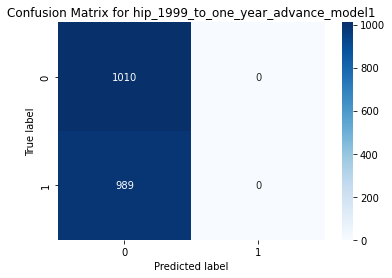

C:\Users\ll15zlh\AppData\Local\Temp\ipykernel_14804\3752875586.py:81: RuntimeWarning: invalid value encountered in longlong_scalars
  PPV = TP/(TP+FP)


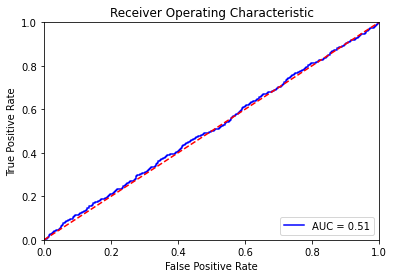

True Positive: 0
True Negative: 1010
False Positive: 0
False Negative: 989

Sensitivity/Recall: 0.000
Specificity: 1.000
Precision/Positive Predictive Value: nan
F1 Score: nan

Accuracy: 0.505
AUROC: 0.507
AUPRC: 0.504


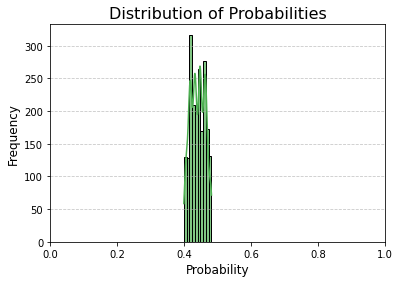

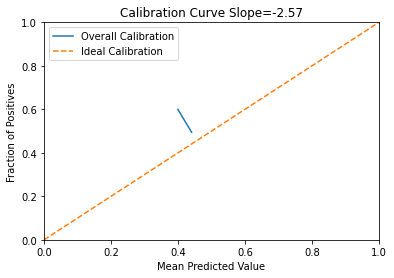

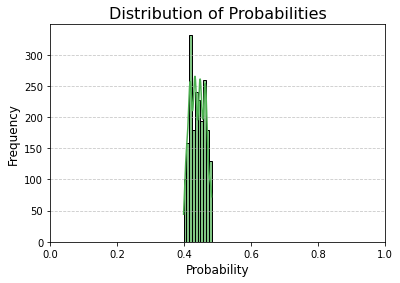

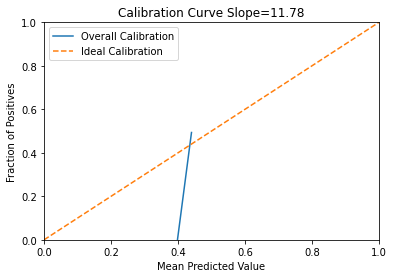

In [14]:
confusion_mat_and_scores(run_name="hip_1999_to_one_year_advance_model1", baseline=False)

###### Baseline models

In [15]:
confusion_mat_and_scores(run_name="LR_only_read_codes_1999_to_one_year_L2", baseline=True)

LR_ONLY_READ_CODES_1999_TO_ONE_YEAR_L2


FileNotFoundError: [Errno 2] No such file or directory: '../pred_proba_and_true/LR_only_read_codes_1999_to_one_year_L2_holdout1_proba.npy'